# K-nearest neighbors

#### Steps for KNN algorithm:
Load the training and testing datasets.
Specify or choose the value of K.
For each point on the test data perform the following:
1. Calculate the distance between the point and each point of the training dataset. We can use Euclidean distance or Manhattan distance.
2. Sort the values in ascending order based on distances.
3. Find the top K values from the sorted list.
4. Find the frequency (Mode) of the labels of the top K values.
5. Assign the mode to the test data point.
6. The assigned value is the classified or predicted value for the particular test data point.

#### Advantage
KNN models are easy to implement and handle non-linearities well. Fitting the model also tends to be quick: the computer doesn’t have to calculate any particular parameters or values, after all. The trade off here is that while the model is quick to set up, it’s slower to predict, since in order to predict an outcome for a new value, it will need to search through all the points in its training set to find the nearest ones. For large datasets, KNN can therefore be a relatively slow method compared to other regressions that may take longer to fit but then make their predictions with relatively straightforward computations.



#### Disadvantage
One other issue with a KNN model is that it lacks interpretability. An OLS linear regression will have clearly interpretable coefficients that can themselves give some indication of the ‘effect size’ of a given feature (although, some caution must taken when assigning causality). Asking which features have the largest effect doesn’t really make sense for a KNN model, however. Partly because of this, KNN models also can’t really be used for feature selection, in the way that a linear regression with an added cost function term, like ridge or lasso, can be, or the way that a decision tree implicitly chooses which features seem most valuable.



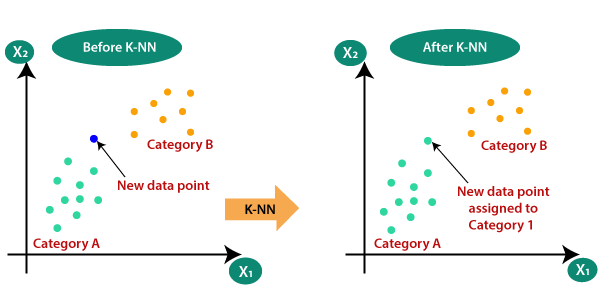

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [14]:
df = pd.read_csv('diabetes.csv', header = 0)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Distribution of outcomes

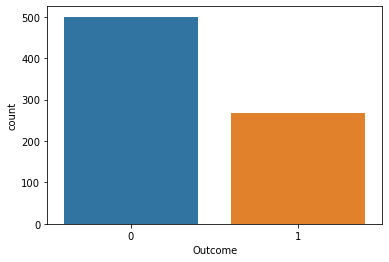

In [15]:
g = sns.countplot(df['Outcome'])
g.set_xticklabels(['0','1'])
plt.show()

The imbalance issue is not so sever so I won't do the sampling balance.

## KNN model

### Normalization

In [16]:
y=df['Outcome']
X=df.drop(['Outcome'],axis=1)

In [28]:
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
stdscalar =StandardScaler()
X_train =  stdscalar.fit_transform(X_train)
X_test =  stdscalar.transform(X_test)

### Tuning the k value

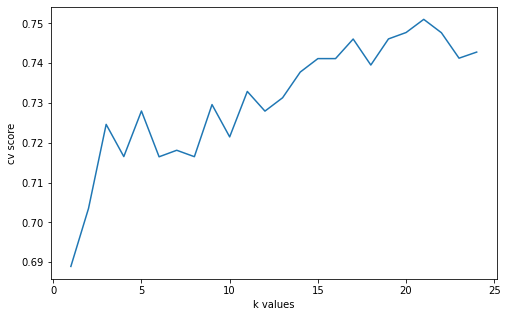

In [29]:
from sklearn.model_selection import cross_val_score
scores = []
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train,y_train)
    score = cross_val_score(estimator=knn, X=X_train, y=y_train, cv=10, n_jobs=4)
    scores.append((k,score.mean()))
plt.figure(figsize=(8,5))    
plt.plot(*zip(*scores))
plt.xlabel("k values")
plt.ylabel("cv score")
plt.show()

Based on the cvscore plot, we find that when k =21, we have the highest score. Thus we choose k=21.

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
knn = KNeighborsClassifier(n_neighbors = 21)
knn.fit(X_train,y_train)

#Predict test data set.
y_pred = knn.predict(X_test)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))

#Checking performance our model with ROC Score.
print('roc score:',roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       107
           1       0.72      0.55      0.63        47

    accuracy                           0.80       154
   macro avg       0.77      0.73      0.74       154
weighted avg       0.79      0.80      0.79       154

roc score: 0.7298667727182342


The roc score is relatively low, so I'd like to do tune the threshold.

### ROC

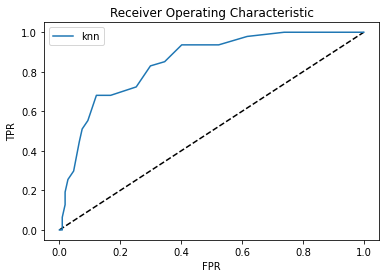

In [31]:
from sklearn.metrics import roc_curve
y_pred_probknn = knn.predict_proba(X_test)[:,1]
fpr , tpr, thresholds = roc_curve(y_test, y_pred_probknn)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label= "knn")

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()


In [32]:
knn = KNeighborsClassifier(n_neighbors = 21)
knn.fit(X_train,y_train)
y_pred_probrknn = knn.predict_proba(X_test)[:,1]
fpr , tpr, thresholds = roc_curve(y_test, y_pred_probrknn)

optimal_idx = np.argmax( tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.47619047619047616

In [33]:
y_pred_knn_best= [1 if prob_knn > optimal_threshold else 0 for prob_knn in y_pred_probrknn]
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_best))
#Checking performance our model with ROC Score.
print('roc score:',roc_auc_score(y_test, y_pred_knn_best))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       107
           1       0.72      0.55      0.63        47

    accuracy                           0.80       154
   macro avg       0.77      0.73      0.74       154
weighted avg       0.79      0.80      0.79       154

roc score: 0.7298667727182342


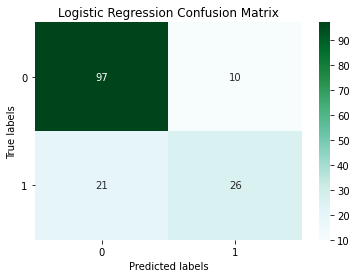

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_knn_best)
ax = plt.subplot()
labels = ['0','1']
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='BuGn') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);


### Conclusion

Eventhough we optmize the threshold, the results dont change much since the optimal threshold is alreay close to 0.5. Probably there is a model misspecification.